## install packages

In [ ]:
# Paper: https://doi.org/10.1016/j.cub.2018.01.080
# https://datadryad.org/stash/dataset/doi:10.5061/dryad.070jc
!pip install mne
!pip install eelbrain
!pip install keyring
!pip install colormath
!pip3 install scipy==1.7.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 4.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 5.3 MB/s 
  Created wheel for eelbrain: filename=eelbrain-0.34.1-cp37-cp37m-linux_x86_64.whl size=2370279 sha256=84f9a42ea07b93d75709ade0b11d8e5f724c02bd6b7b03994388aa7afff22e90
  Stored in directory: /root/.cache/pip/wheels/9a/29/05/ab95c10411d2661330dd88582ff9a4e96f640a0e31ff3205ae
Successfully built eelbrain
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48 kB 4.4 MB/s 
     |████████████████████████████████| 4.1 MB 10.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for colormath: filename=colormath-3.0.0-py3-none-any.whl 

## Download files

In [ ]:
!wget -O natural_reading_eeg.zip https://datadryad.org/stash/downloads/file_stream/222587

## Retrieve file

In [ ]:
## Channel layout
# https://github.com/mne-tools/mne-python/blob/main/mne/channels/data/montages/biosemi128.txt
# https://www.biosemi.com/pics/cap_128_layout_medium.jpg
!unzip -q natural_reading_eeg.zip
!mv "Natural Speech" data # rename folder "Natural Speech" as "data"
!ls data/EEG

## import packages

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import scipy.io as sio # scipy.io.loadmat
from scipy import stats
import numpy as np
import mne
import eelbrain
from itertools import islice

In [ ]:
%matplotlib inline

## prepare functions

In [ ]:
def get_raw_EEG(Sid, runid):
  audio = sio.loadmat("data/Stimuli/Envelopes/audio%d_128Hz.mat"%runid)
  text = sio.loadmat("data/Stimuli/Text/Run%d.mat"%runid)
  EEG = sio.loadmat("data/EEG/Subject%d/Subject%d_Run%d.mat"%(Sid,Sid,runid))
  eeg_scalp = EEG["eegData"] # time by channels
  eeg_mas = EEG["mastoids"]

  # time by channels >> channels by times
  eeg_scalp = np.transpose( eeg_scalp, (1, 0)) 
  eeg_mas = np.transpose( eeg_mas, (1, 0)) 

  eeg_ = np.concatenate((eeg_scalp, eeg_mas), axis = 0)
  audio = audio["env"]
  if eeg_.shape[1] > audio.shape[0]:
      eeg_ = eeg_[:, :audio.shape[0]]
  
  if eeg_.shape[1] < audio.shape[0]:
      audio = audio[:eeg_.shape[1]]

  tstep = 1. / 128
  n_times = audio.shape[0]
  time = eelbrain.UTS(0, tstep, n_times)
  envelope = eelbrain.NDVar(audio.ravel(), (time,), name='envelope')

  temp = mne.channels.make_standard_montage("biosemi128")
  ch_names = temp.ch_names
  ch_names.append("M1")
  ch_names.append("M2")
  ch_types = ['eeg'] * 130
  info = mne.create_info(ch_names, ch_types=ch_types, sfreq=128)

  raw = mne.io.RawArray(eeg_ * 1e-6, info)
  raw.set_eeg_reference(["M1", "M2"]).pick('all', exclude=["M1", "M2"]).set_montage('biosemi128')
  print(raw)

  return raw, envelope, time

def raw2NDvar(raw, time):
  montage_x = eelbrain.load.fiff.sensor_dim(raw.info)
  temp_data = raw.get_data().T *1e+6
  eegNDVar = eelbrain.NDVar(temp_data, (time, montage_x), name='EEG', info={'unit': 'µV'})
  return eegNDVar

def word_onsets_NDVar(runid, time):
  text = sio.loadmat("data/Stimuli/Text/Run%d.mat"%runid)
  words = [x[0][0] for x in text["wordVec"]]
  onsets = [x[0] for x in text["onset_time"]]

  onset_word = eelbrain.NDVar(np.zeros(len(time)), time, name='Word_on')
  for x in onsets:
      onset_word[x] = 1
      pass
  return onset_word

In [ ]:
EEG = sio.loadmat("data/EEG/Subject%d/Subject%d_Run%d.mat"%(Sid,Sid,runid))
eeg_ = EEG["eegData"] # time by channels

# time by channels >> channels by times
eeg_ = np.transpose( eeg_scalp, (1, 0)) 

temp = mne.channels.make_standard_montage("biosemi128")
ch_names = temp.ch_names # ['Cz', 'Fz', ...]
ch_types = ['eeg'] * 128
info = mne.create_info(ch_names, ch_types=ch_types, sfreq=128)
raw = mne.io.RawArray(eeg_ * 1e-6, info)
raw.set_montage('biosemi128')

# TODO:
# events = ...
# event_id = {'Condition1':1, 'Condition2':2, ...}

NameError: ignored

## EEG Data

In [ ]:
#eeg_data = sio.loadmat("data/EEG/Subject1/Subject1_Run1.mat")
#eeg = eeg_data["eegData"] # time by channels
#mastoids = eeg_data["mastoids"]
#print(eeg.shape)

Sid = 7
raw, envelope, time = get_raw_EEG(Sid, 1)
raw.filter(1, 20)
eegNDVar = raw2NDvar(raw, time)

#raw.plot()
#p = eelbrain.plot.TopoButterfly(eegNDVar, xlim=5, w=7, h=2)
#p.set_time(1.300)

Creating RawArray with float64 data, n_channels=130, n_times=22729
    Range : 0 ... 22728 =      0.000 ...   177.562 secs
Ready.
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
<RawArray | 128 x 22729 (177.6 s), ~22.4 MB, data loaded>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.2s finished


Fitting ICA to data using 128 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 4.6s.
Creating RawArray with float64 data, n_channels=15, n_times=22729
    Range : 0 ... 22728 =      0.000 ...   177.562 secs
Ready.
Using matplotlib as 2D backend.


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


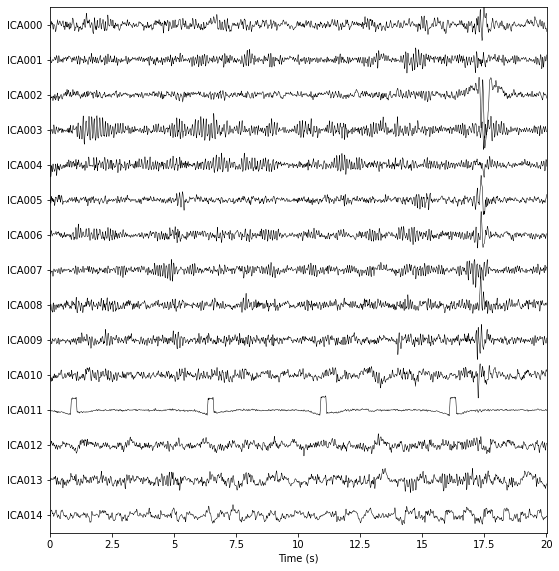

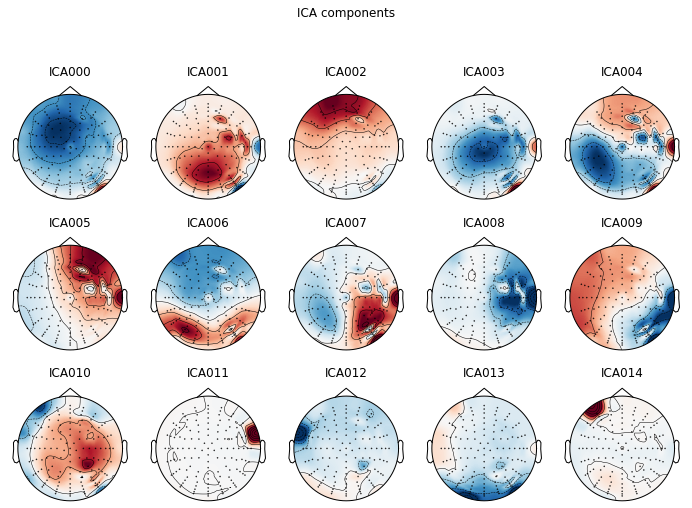

[<MNEFigure size 702x526.68 with 15 Axes>]

In [ ]:
ica = mne.preprocessing.ICA(n_components=15, max_iter='auto', random_state=97)
ica.fit(raw)
ica.plot_sources(raw, show_scrollbars=False)
ica.plot_components()

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 128 PCA components


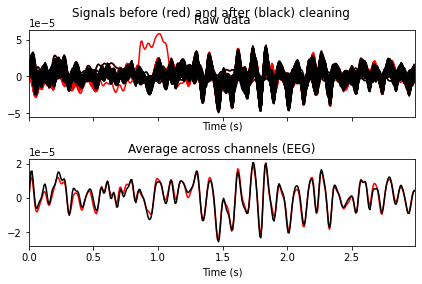

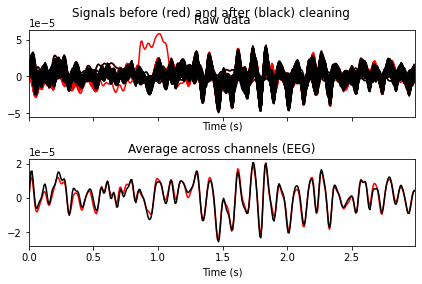

In [ ]:
ica.plot_overlay(raw, exclude=[2, 11], picks='eeg')
# Sid-1:0, 1; Sid-2:0, 9; Sid-3:3, 11, 12; Sid-4:2, 6, 12
#ica.plot_properties(raw, picks=[0, 1, 4, 9])

In [ ]:
ica.exclude = [2, 11]
ica.apply(raw)
eegNDVar = raw2NDvar(raw, time)

raw2, envelope2, time2 = get_raw_EEG(Sid, 2)
raw2.filter(1, 20)
ica.apply(raw2)
eegNDVar2 = raw2NDvar(raw2, time2)

raw3, envelope3, time3 = get_raw_EEG(Sid, 3)
raw3.filter(1, 20)
ica.apply(raw3)
eegNDVar3 = raw2NDvar(raw3, time3)

raw4, envelope4, time4 = get_raw_EEG(Sid, 4)
raw4.filter(1, 20)
ica.apply(raw4)
eegNDVar4 = raw2NDvar(raw4, time4)

raw5, envelope5, time5 = get_raw_EEG(Sid, 5)
raw5.filter(1, 20)
ica.apply(raw5)
eegNDVar5 = raw2NDvar(raw5, time5)


raw6, envelope6, time6 = get_raw_EEG(Sid, 6)
raw6.filter(1, 20)
ica.apply(raw6)
eegNDVar6 = raw2NDvar(raw6, time6)

raw7, envelope7, time7 = get_raw_EEG(Sid, 7)
raw7.filter(1, 20)
ica.apply(raw7)
eegNDVar7 = raw2NDvar(raw7, time7)

raw8, envelope8, time8 = get_raw_EEG(Sid, 8)
raw8.filter(1, 20)
ica.apply(raw8)
eegNDVar8 = raw2NDvar(raw8, time8)

raw9, envelope9, time9 = get_raw_EEG(Sid, 9)
raw9.filter(1, 20)
ica.apply(raw9)
eegNDVar9 = raw2NDvar(raw9, time9)

raw10, envelope10, time10 = get_raw_EEG(Sid, 10)
raw10.filter(1, 20)
ica.apply(raw10)
eegNDVar10 = raw2NDvar(raw10, time10)

env_ = eelbrain.concatenate([envelope, envelope2, envelope3, envelope4, envelope5, envelope6, .... envelope10])
eegNDVar_ = eelbrain.concatenate([eegNDVar, eegNDVar2, eegNDVar3, eegNDVar4, eegNDVar5, eegNDVar6, ....])

onset_word = word_onsets_NDVar(1, time)
onset_word2 = word_onsets_NDVar(2, time2)
onset_word3 = word_onsets_NDVar(3, time3)
onset_word4 = word_onsets_NDVar(4, time4)
onset_word5 = word_onsets_NDVar(5, time5)


onset_word6 = word_onsets_NDVar(6, time6)
onset_word7 = word_onsets_NDVar(7, time7)
onset_word8 = word_onsets_NDVar(8, time8)
onset_word9 = word_onsets_NDVar(9, time9)
onset_word10 = word_onsets_NDVar(10, time10)

w_on = eelbrain.concatenate([onset_word, onset_word2, onset_word3, onset_word4, onset_word5, onset_word6, ... ])

#eelbrain.plot.UTS(onset_word, xlim=10, w=6, h=2)


Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 128 PCA components
Creating RawArray with float64 data, n_channels=130, n_times=23130
    Range : 0 ... 23129 =      0.000 ...   180.695 secs
Ready.
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
<RawArray | 128 x 23130 (180.7 s), ~22.8 MB, data loaded>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 128 PCA components


[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=130, n_times=23050
    Range : 0 ... 23049 =      0.000 ...   180.070 secs
Ready.
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
<RawArray | 128 x 23050 (180.1 s), ~22.7 MB, data loaded>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.2s finished


Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 128 PCA components
Creating RawArray with float64 data, n_channels=130, n_times=23213
    Range : 0 ... 23212 =      0.000 ...   181.344 secs
Ready.
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
<RawArray | 128 x 23213 (181.3 s), ~22.8 MB, data loaded>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.2s finished


Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 128 PCA components
Creating RawArray with float64 data, n_channels=130, n_times=23082
    Range : 0 ... 23081 =      0.000 ...   180.320 secs
Ready.
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
<RawArray | 128 x 23082 (180.3 s), ~22.7 MB, data loaded>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 128 PCA components


[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.2s finished


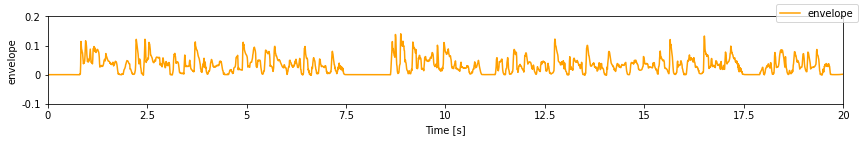

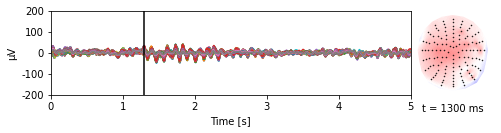

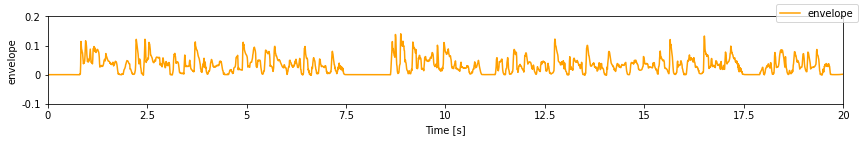

In [ ]:
p = eelbrain.plot.TopoButterfly(eegNDVar, xlim=5, w=7, h=2)
p.set_time(1.300)

#eelbrain.plot.UTS(envelope, w=6, h=2)
eelbrain.plot.UTS(envelope, xlim=20, w=12, h=2)

Fitting models:   0%|          | 0/2560 [00:00<?, ?it/s]

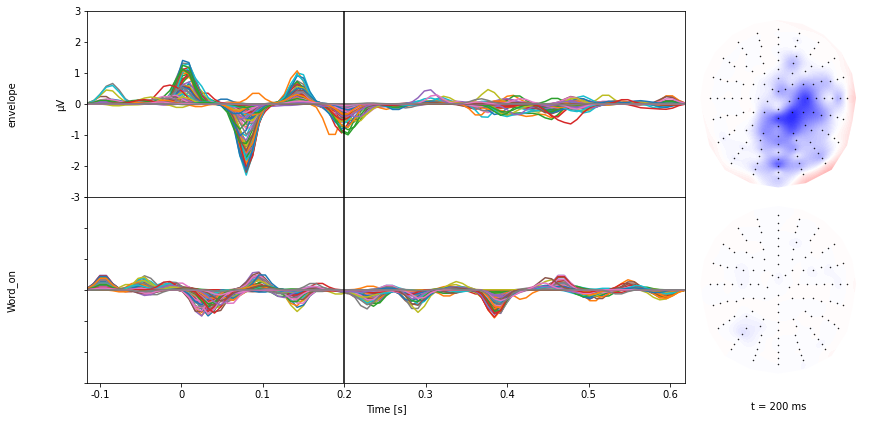

In [ ]:
TRF_2var = eelbrain.boosting(eegNDVar_, [env_, w_on],  -0.1, 0.6, error='l1',
                        basis=0.050, partitions=5, test=1, selective_stopping=True)

eelbrain.save.pickle(TRF_2var, 'Subj%d_TRFs_envelop_w_on.pickle'%(Sid))



TRF_1var = eelbrain.boosting(eegNDVar_, [env_],  -0.1, 0.6, error='l1',
                        basis=0.050, partitions=5, test=1, selective_stopping=True)

eelbrain.save.pickle(TRF_1var, 'Subj%d_TRFs_envelop.pickle'%(Sid))


p = eelbrain.plot.TopoButterfly(TRF_2var.h_scaled, w=12, h=6)
p.set_time(.20)

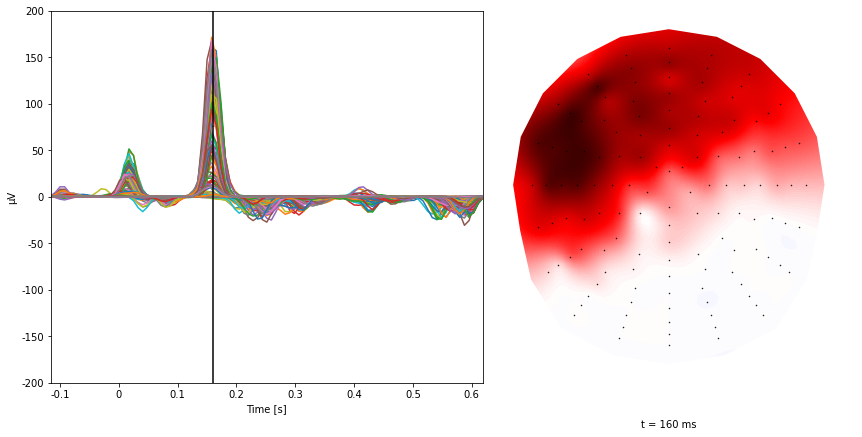

In [ ]:
p = eelbrain.plot.TopoButterfly(TRF_2var.h_scaled[0], w=12, h=6)
p.set_time(.16)

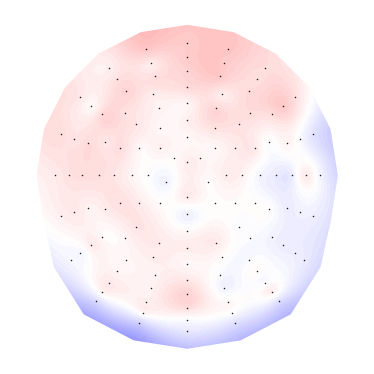

In [ ]:
p = eelbrain.plot.Topomap(res.proportion_explained, w=6, h=5)
p.set_vlim(-0.005, 0.005)

In [ ]:
!ls

drive				Subj4_TRFs_envelop_w_on.pickle
sample_data			Subj5_TRFs_envelop_w_on.pickle
Subj1_TRFs_envelop_w_on.pickle	Subj6_TRFs_envelop_w_on.pickle
Subj2_TRFs_envelop_w_on.pickle	Subj7_TRFs_envelop_w_on.pickle
Subj3_TRFs_envelop_w_on.pickle


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


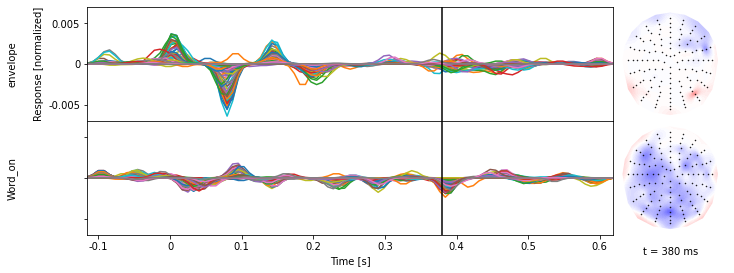

In [ ]:
Subj = 7
res = eelbrain.load.unpickle('Subj%d_TRFs_envelop_w_on.pickle'%(Subj))
#p = eelbrain.plot.TopoButterfly(res.h_scaled, w=10, h=4)
p = eelbrain.plot.TopoButterfly(res.h, w=10, h=4)
p.set_time(.38)

In [ ]:
#TRF_2var = eelbrain.boosting(eegNDVar_, [env_, w_on],  -0.1, 0.6, error='l1',
#                        basis=0.050, partitions=5, test=1, selective_stopping=True)



print(res.proportion_explained.x)

In [ ]:
SUBJECTS = ['1', '2', '3', '4', '5', '6', '7']
rows = []
for subject in SUBJECTS:
    trf = eelbrain.load.unpickle('Subj%s_TRFs_envelop_w_on.pickle'%(subject))
    rows.append([subject, trf.proportion_explained, trf.h[0].abs()])
    pass
data_env = eelbrain.Dataset.from_caselist(['subject', 'det', 'trf'], rows)

In [ ]:
rows 

[['1', <NDVar '1': 128 sensor>, <NDVar 'envelope': 128 sensor, 95 time>],
 ['2', <NDVar '1': 128 sensor>, <NDVar 'envelope': 128 sensor, 95 time>],
 ['3', <NDVar '1': 128 sensor>, <NDVar 'envelope': 128 sensor, 95 time>],
 ['4', <NDVar '1': 128 sensor>, <NDVar 'envelope': 128 sensor, 95 time>],
 ['5', <NDVar '1': 128 sensor>, <NDVar 'envelope': 128 sensor, 95 time>],
 ['6', <NDVar '1': 128 sensor>, <NDVar 'envelope': 128 sensor, 95 time>],
 ['7', <NDVar '1': 128 sensor>, <NDVar 'envelope': 128 sensor, 95 time>]]

In [ ]:
rows

[['1', <NDVar '1': 128 sensor>, <NDVar 'envelope': 128 sensor, 95 time>],
 ['2', <NDVar '1': 128 sensor>, <NDVar 'envelope': 128 sensor, 95 time>],
 ['3', <NDVar '1': 128 sensor>, <NDVar 'envelope': 128 sensor, 95 time>],
 ['4', <NDVar '1': 128 sensor>, <NDVar 'envelope': 128 sensor, 95 time>],
 ['5', <NDVar '1': 128 sensor>, <NDVar 'envelope': 128 sensor, 95 time>],
 ['6', <NDVar '1': 128 sensor>, <NDVar 'envelope': 128 sensor, 95 time>],
 ['7', <NDVar '1': 128 sensor>, <NDVar 'envelope': 128 sensor, 95 time>]]

In [ ]:
data_env

subject
1
2
3
4
5
6
7


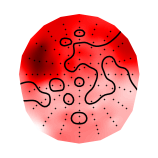

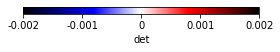

In [ ]:
#test that model predictive power on held-out data is > 0
test_envelope = eelbrain.testnd.TTestOneSample('det', ds=data_env, tail=1, pmin=0.1)
p = eelbrain.plot.Topomap(test_envelope)
cb = p.plot_colorbar(width=0.1)

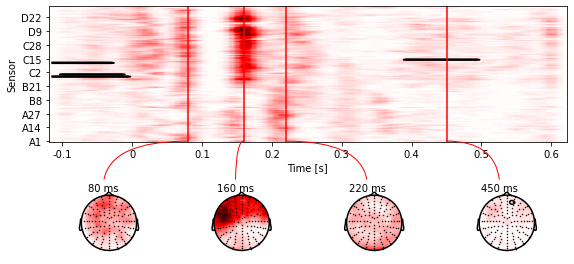

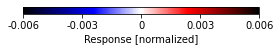

In [ ]:
# ## Envelope TRF
# Test the TRF with a one-sample *t*-test against 0. This tests the null-hypothesis that the electrical current direction at each time point was random across subjects. The systematic current directions shown below at anterior electrodes are typical of auditory responses. 

trf_envelope = eelbrain.testnd.TTestOneSample('trf', ds=data_env, pmin=0.1)

p = eelbrain.plot.TopoArray(trf_envelope, t=[0.08, 0.16, 0.22, 0.45], clip='circle', cmap='xpolar', h=4, w = 8)
cb = p.plot_colorbar(width=0.1)



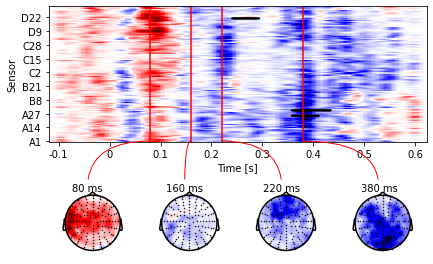

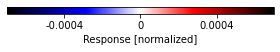

In [ ]:
rows = []
for subject in SUBJECTS:
    trf = eelbrain.load.unpickle('Subj%s_TRFs_envelop_w_on.pickle'%(subject))
    rows.append([subject, trf.proportion_explained, trf.h[1]])
    pass
data_won = eelbrain.Dataset.from_caselist(['subject', 'det', 'wordon'], rows)

trf_won = eelbrain.testnd.TTestOneSample('wordon', ds=data_won, pmin=0.1)

p = eelbrain.plot.TopoArray(trf_won, t=[0.08, 0.16, 0.22, 0.38], clip='circle', cmap='xpolar')
cb = p.plot_colorbar(width=0.1)
